### <span style="color:teal"> __NETWORK ANALYSIS DISEASE UNIPARTITE GENUS NETWORK__ 

<span style="color:teal"> In a disease‐centric unipartite genus network, diseases are represented as nodes, and an edge is drawn between two diseases when they share one or more microbial genera with statistically significant associations. This projection is derived from an underlying disease–genus bipartite network, where the intermediate microbial genera serve as the basis for linking diseases. Such a network highlights the similarity in microbial profiles between different diseases, capturing patterns of shared dysbiosis. By focusing on disease–disease connections, it allows us to explore potential comorbidity patterns, identify disease clusters with overlapping microbial signatures, and generate hypotheses about common pathophysiological mechanisms that may be mediated by the gut microbiome. This approach shifts the perspective from individual taxa to the broader relationships between diseases, providing a systems‐level view of microbiome–host interactions.


In [41]:
# LOADING REQUIRED PACKAGES
from collections import Counter
import itertools
import json
import powerlaw
from kneed import KneeLocator
import pickle

# NetworkX and Seaborn
from networkx.algorithms import bipartite
import seaborn as sns
from collections import defaultdict

# === Third-Party Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.patches import Patch

import matplotlib.ticker as ticker 

from adjustText import adjust_text
import networkx as nx
from networkx.algorithms import bipartite
import community as community_louvain  # Louvain community detection (python-louvain)
import textwrap
# Optional: Configure matplotlib to use a specific style or suppress warnings
# plt.style.use('seaborn-whitegrid')  # optional, if you want a consistent style

print("Network X version = ",nx.__version__)



Network X version =  3.4.2


In [42]:
# LOADING GENUS DATA
df_genus = pd.read_csv("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/diff_taxa_abundance_analysis/significant_genus_taxa.txt", sep="\t")
df_genus_network = df_genus[["disease", "ncbi_taxon_id"]].drop_duplicates()
df_genus_network


disease  ncbi_taxon_id
0          D003924            570
1          D003924            841
2          D003924            872
3          D003924            904
4          D003924            906
...            ...            ...
410647     D037841        1348911
410662  D000067877         123375
410693     D016640         946234
410770     D016640         158846
410771     D037841         158846

[2335 rows x 2 columns]

In [43]:
# LOADING DICTIONARY DISEASE NAMES AND DISEASE CATEGORIES

# Open the JSON file containing disease name mappings
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/disease_dict.json", "r") as f:
    # Load the contents of the JSON file into a Python dictionary
    disease_dict = json.load(f)
    
# Open hte JSOn file contaiing the disease classificaiton data
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/disease_classification.json", "r") as f:
    disease_classification = json.load(f)


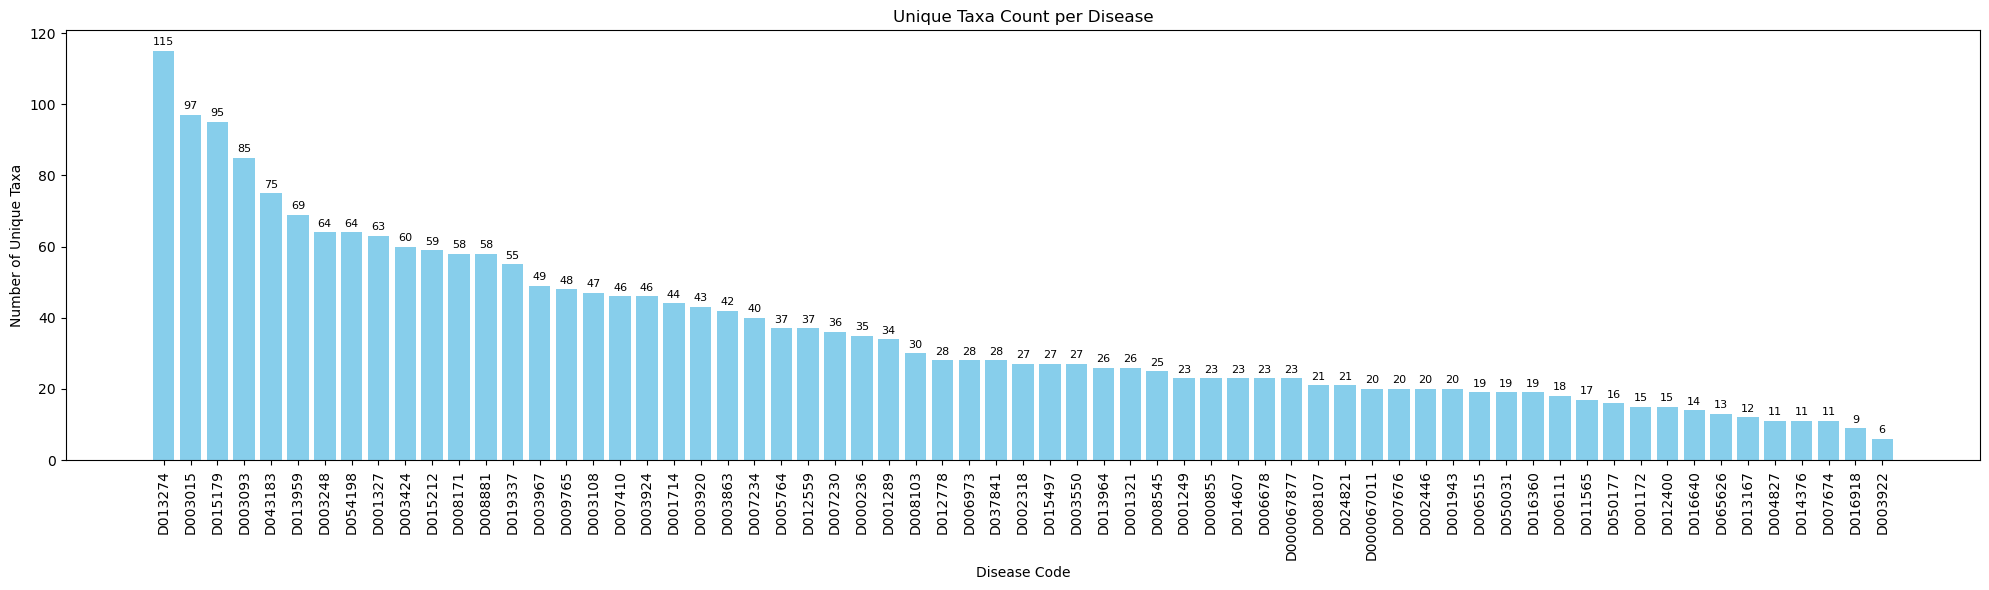

In [44]:
# Data Descritption
# Group and count unique taxa per disease
taxa_counts = (
    df_genus_network.groupby("disease")["ncbi_taxon_id"]
    .nunique()
    .reset_index(name="unique_taxa_count")
    .sort_values("unique_taxa_count", ascending=False)
)

# Plot
fig, ax = plt.subplots(figsize=(20, 6))
bars = ax.bar(taxa_counts["disease"], taxa_counts["unique_taxa_count"], color="skyblue")

# Add count labels above bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,  # position above the bar
        str(height),
        ha='center',
        va='bottom',
        fontsize=8
    )

# Formatting
ax.set_xlabel("Disease Code")
ax.set_ylabel("Number of Unique Taxa")
ax.set_title("Unique Taxa Count per Disease")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### __UBIQUITY FILTER__

Elbow-based ubiquity threshold: 30


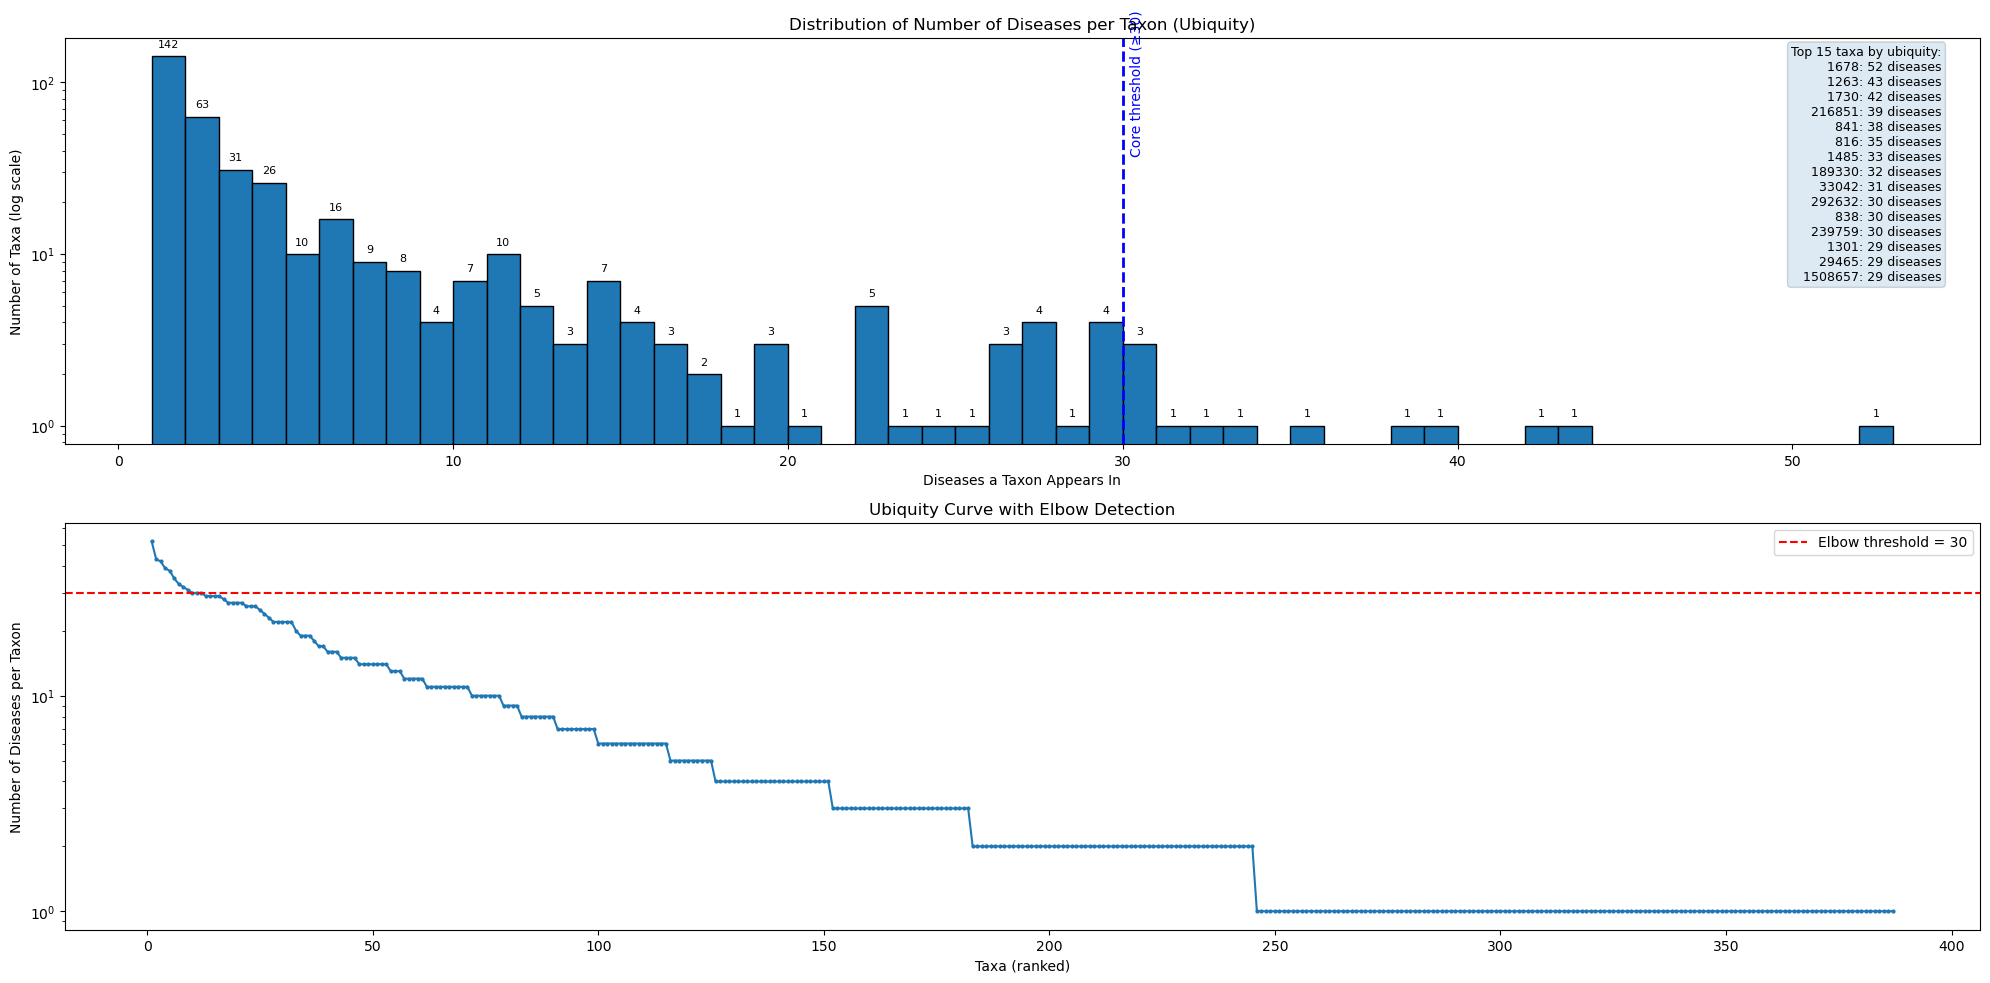

In [45]:
# --- CONFIG ---
TOP_N = 15
UBIQ_THRESHOLD = 25  # default, will be replaced by elbow if found
FIGSIZE = (20, 10)

# 1) Ensure unique (disease, taxon)
dfu = df_genus_network[["disease", "ncbi_taxon_id"]].drop_duplicates()

# 2) Calculate ubiquity (distinct diseases per taxon)
taxon_ubiquity = (
    dfu.groupby("ncbi_taxon_id")["disease"]
       .nunique()
       .sort_values(ascending=False)
       .rename("ubiquity")
)

# 3) KneeLocator to find elbow threshold
x = np.arange(1, len(taxon_ubiquity) + 1)
y = taxon_ubiquity.values
kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
elbow_value = int(y[kneedle.knee - 1]) if kneedle.knee is not None else None
if elbow_value:
    UBIQ_THRESHOLD = elbow_value

print(f"Elbow-based ubiquity threshold: {UBIQ_THRESHOLD}")

# 4) Prepare figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=FIGSIZE)

# --- Subplot 1: Histogram ---
bins = np.arange(1, taxon_ubiquity.max() + 2)
counts, edges, patches = axes[0].hist(taxon_ubiquity, bins=bins, edgecolor='black')
axes[0].set_yscale("log")
axes[0].set_xlabel("Diseases a Taxon Appears In")
axes[0].set_ylabel("Number of Taxa (log scale)")
axes[0].set_title("Distribution of Number of Diseases per Taxon (Ubiquity)")

# Add labels on top of bars
for count, edge in zip(counts, edges):
    if count > 0:
        axes[0].text(edge + 0.5, count * 1.1,
                     f"{int(count)}", ha="center", va="bottom", fontsize=8)

# Threshold line
axes[0].axvline(UBIQ_THRESHOLD, linestyle="--", linewidth=2, color='blue')
axes[0].text(UBIQ_THRESHOLD + 0.2, max(counts[counts > 0]) * 0.7,
             f"Core threshold (≥{UBIQ_THRESHOLD})",
             rotation=90, va="center", color='blue')

# Top taxa annotation
top_rows = taxon_ubiquity.head(TOP_N)
top_text = "\n".join([f"{int(tid)}: {ub} diseases" for tid, ub in top_rows.items()])
props = dict(boxstyle="round", alpha=0.15)
axes[0].text(0.98, 0.98, f"Top {TOP_N} taxa by ubiquity:\n{top_text}",
             transform=axes[0].transAxes, ha="right", va="top", bbox=props, fontsize=9)

# --- Subplot 2: Ubiquity rank curve ---
axes[1].plot(x, y, marker='o', markersize=2)
if elbow_value:
    axes[1].axhline(elbow_value, color='red', linestyle='--',
                    label=f"Elbow threshold = {elbow_value}")
axes[1].set_yscale("log")
axes[1].set_xlabel("Taxa (ranked)")
axes[1].set_ylabel("Number of Diseases per Taxon")
axes[1].set_title("Ubiquity Curve with Elbow Detection")
axes[1].legend()

# --- Show only ---
plt.tight_layout()
plt.show()


In [46]:
# POST UBIQUITY FILTERING SUMMARY
# 1) Ensure unique (disease, taxon) pairs
dfu = df_genus_network[["disease", "ncbi_taxon_id"]].drop_duplicates()

# 2) Calculate ubiquity (number of distinct diseases per taxon)
taxon_ubiquity = (
    dfu.groupby("ncbi_taxon_id")["disease"]
       .nunique()
       .sort_values(ascending=False)
       .rename("ubiquity")
)

# 3) Find elbow threshold
x = np.arange(1, len(taxon_ubiquity) + 1)
y = taxon_ubiquity.values
kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
elbow_value = int(y[kneedle.knee - 1]) if kneedle.knee is not None else None


# 4) Remove high-ubiquity taxa (keep only those BELOW threshold)
if elbow_value:
    low_ubiquity_taxa = taxon_ubiquity[taxon_ubiquity < elbow_value].index
    df_genus_network_filtered = df_genus_network[df_genus_network["ncbi_taxon_id"].isin(low_ubiquity_taxa)]
else:
    df_genus_network_filtered = df_genus_network.copy()


# =====================================================
# 5) Detailed Filtering Summary
# =====================================================
total_taxa = df_genus_network["ncbi_taxon_id"].nunique()
filtered_taxa = df_genus_network_filtered["ncbi_taxon_id"].nunique()
removed_taxa = total_taxa - filtered_taxa

total_diseases = df_genus_network["disease"].nunique()
diseases_after = df_genus_network_filtered["disease"].nunique()

avg_ubiq_after = (
    dfu[dfu["ncbi_taxon_id"].isin(df_genus_network_filtered["ncbi_taxon_id"])]
    .groupby("ncbi_taxon_id")["disease"]
    .nunique()
    .mean()
)

print("\n=== Ubiquity Filtering Summary ===")
print(f"Ubiquity threshold applied: {elbow_value if elbow_value else 'None'}")
print(f"Original total rows: {len(df_genus_network):,}")
print(f"Remaining rows after filtering: {len(df_genus_network_filtered):,}")
print(f"Original number of unique taxa: {total_taxa:,}")
print(f"Number of unique taxa removed: {removed_taxa:,} ({removed_taxa/total_taxa:.1%} of taxa)")
print(f"Number of unique taxa kept: {filtered_taxa:,}")
print(f"Original number of diseases: {total_diseases:,}")
print(f"Diseases retained after filtering: {diseases_after:,} ({diseases_after/total_diseases:.1%} of diseases still connected)")
print(f"Average ubiquity (before): {taxon_ubiquity.mean():.2f} diseases/taxon")
print(f"Average ubiquity (after): {avg_ubiq_after:.2f} diseases/taxon")

# Show top 5 most ubiquitous taxa removed
if elbow_value:
    removed_taxa_ids = taxon_ubiquity[taxon_ubiquity >= elbow_value].head(5)
    print("\nTop 5 most ubiquitous taxa removed:")
    for tid, ubiq in removed_taxa_ids.items():
        print(f"  Taxon {tid}: {ubiq} diseases")




=== Ubiquity Filtering Summary ===
Ubiquity threshold applied: 30
Original total rows: 2,335
Remaining rows after filtering: 1,900
Original number of unique taxa: 387
Number of unique taxa removed: 12 (3.1% of taxa)
Number of unique taxa kept: 375
Original number of diseases: 65
Diseases retained after filtering: 65 (100.0% of diseases still connected)
Average ubiquity (before): 6.03 diseases/taxon
Average ubiquity (after): 5.07 diseases/taxon

Top 5 most ubiquitous taxa removed:
  Taxon 1678: 52 diseases
  Taxon 1263: 43 diseases
  Taxon 1730: 42 diseases
  Taxon 216851: 39 diseases
  Taxon 841: 38 diseases


### <span style="color:teal"> __BIPARTITE DISEASE-TAXON NETWORK__


Bipartite Disease–Taxa Network Summary
--------------------------------------
Nodes: 440  |  Edges: 1900
  • Diseases (U): 65
  • Taxa     (V): 375

Edge density (E / U×V): 0.077949  (range: 0 = no edges, 1 = fully connected)

Degree stats — Diseases (neighbors per disease)
  mean: 29.231  |  median: 21.000
  min:  2   |  max:    108
  std:  21.744   |  IQR:    25.000
  Q25:  14.000   |  Q75:    39.000

Degree stats — Taxa (neighbors per taxon)
  mean: 5.067     |  median: 2.000
  min:  1      |  max:    29
  std:  6.402      |  IQR:    5.000
  Q25:  1.000      |  Q75:    6.000



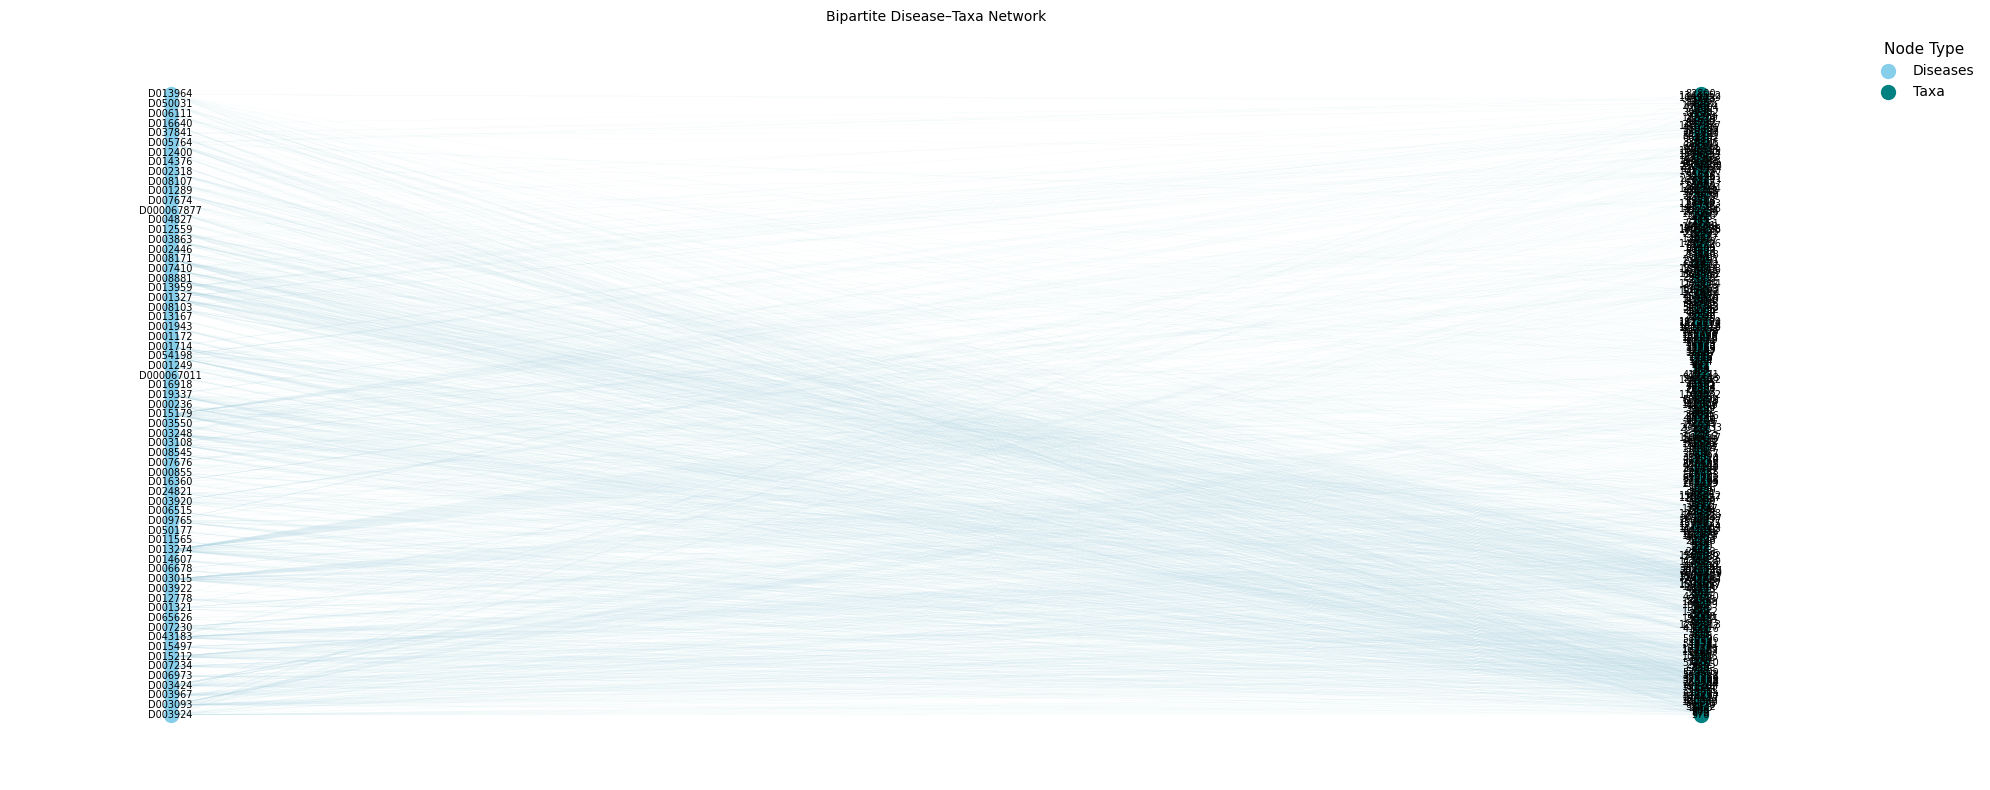

In [47]:
# === Build bipartite ===
B = nx.Graph()

# unique nodes for each layer
diseases = df_genus_network_filtered['disease'].unique()
taxa = df_genus_network_filtered['ncbi_taxon_id'].astype(str).unique()

# add nodes with bipartite attribute
B.add_nodes_from(diseases, bipartite=0)  # layer 0 = diseases
B.add_nodes_from(taxa, bipartite=1)      # layer 1 = taxa

# add edges
edges = df_genus_network_filtered[['disease', 'ncbi_taxon_id']].drop_duplicates()
edges['ncbi_taxon_id'] = edges['ncbi_taxon_id'].astype(str)
B.add_edges_from(edges.values.tolist())

# === Separate nodes ===
disease_nodes = [n for n in B.nodes() if B.nodes[n]['bipartite'] == 0]
taxa_nodes    = [n for n in B.nodes() if B.nodes[n]['bipartite'] == 1]

# === Density (bipartite) ===
E = B.number_of_edges()
U = len(disease_nodes)
V = len(taxa_nodes)
max_possible_edges = U * V
density = E / max_possible_edges if max_possible_edges > 0 else float('nan')

# === Degree stats helper ===
def degree_stats(G, nodes):
    deg = np.array([G.degree(n) for n in nodes], dtype=float)
    if deg.size == 0:
        return dict(mean=np.nan, median=np.nan, min=np.nan, max=np.nan,
                    std=np.nan, q25=np.nan, q75=np.nan, iqr=np.nan)
    return dict(
        mean   = float(deg.mean()),
        median = float(np.median(deg)),
        min    = float(deg.min()),
        max    = float(deg.max()),
        std    = float(deg.std(ddof=0)),
        q25    = float(np.percentile(deg, 25)),
        q75    = float(np.percentile(deg, 75)),
        iqr    = float(np.percentile(deg, 75) - np.percentile(deg, 25)),
    )

disease_deg = degree_stats(B, disease_nodes)
taxa_deg    = degree_stats(B, taxa_nodes)

# === Descriptive summary ===
print(f"""
Bipartite Disease–Taxa Network Summary
--------------------------------------
Nodes: {B.number_of_nodes()}  |  Edges: {E}
  • Diseases (U): {U}
  • Taxa     (V): {V}

Edge density (E / U×V): {density:.6f}  (range: 0 = no edges, 1 = fully connected)

Degree stats — Diseases (neighbors per disease)
  mean: {disease_deg['mean']:.3f}  |  median: {disease_deg['median']:.3f}
  min:  {disease_deg['min']:.0f}   |  max:    {disease_deg['max']:.0f}
  std:  {disease_deg['std']:.3f}   |  IQR:    {disease_deg['iqr']:.3f}
  Q25:  {disease_deg['q25']:.3f}   |  Q75:    {disease_deg['q75']:.3f}

Degree stats — Taxa (neighbors per taxon)
  mean: {taxa_deg['mean']:.3f}     |  median: {taxa_deg['median']:.3f}
  min:  {taxa_deg['min']:.0f}      |  max:    {taxa_deg['max']:.0f}
  std:  {taxa_deg['std']:.3f}      |  IQR:    {taxa_deg['iqr']:.3f}
  Q25:  {taxa_deg['q25']:.3f}      |  Q75:    {taxa_deg['q75']:.3f}
""")

# === Plot ===
pos = nx.bipartite_layout(B, disease_nodes)

plt.figure(figsize=(20, 8))
nx.draw_networkx_nodes(B, pos, nodelist=disease_nodes, node_color="skyblue", node_size=100, label="Diseases")
nx.draw_networkx_nodes(B, pos, nodelist=taxa_nodes, node_color="teal",     node_size=100, label="Taxa")
nx.draw_networkx_edges(B, pos, alpha=0.35, width=0.1, edge_color='lightblue')
nx.draw_networkx_labels(B, pos, font_size=7)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=10,
           title="Node Type", title_fontsize=11)
plt.axis("off")
plt.title("Bipartite Disease–Taxa Network", fontsize=10)
plt.tight_layout()
plt.show()


### <span style="color:teal"> __UNIPARTITE PROJECTION__

<span style="color:teal"> __1. DISEASE-DISEASE__

<span style="color:teal"> __2. TAXA-TAXA__


Disease–Disease Unipartite Summary:
- Nodes: 65
- Edges: 1930
- Density: 0.9279
- Degree: mean 59.38, median 62.00, min 30, max 64


Taxa–Taxa Unipartite Summary:
- Nodes: 375
- Edges: 23415
- Density: 0.3339
- Degree: mean 124.88, median 107.00, min 15, max 319



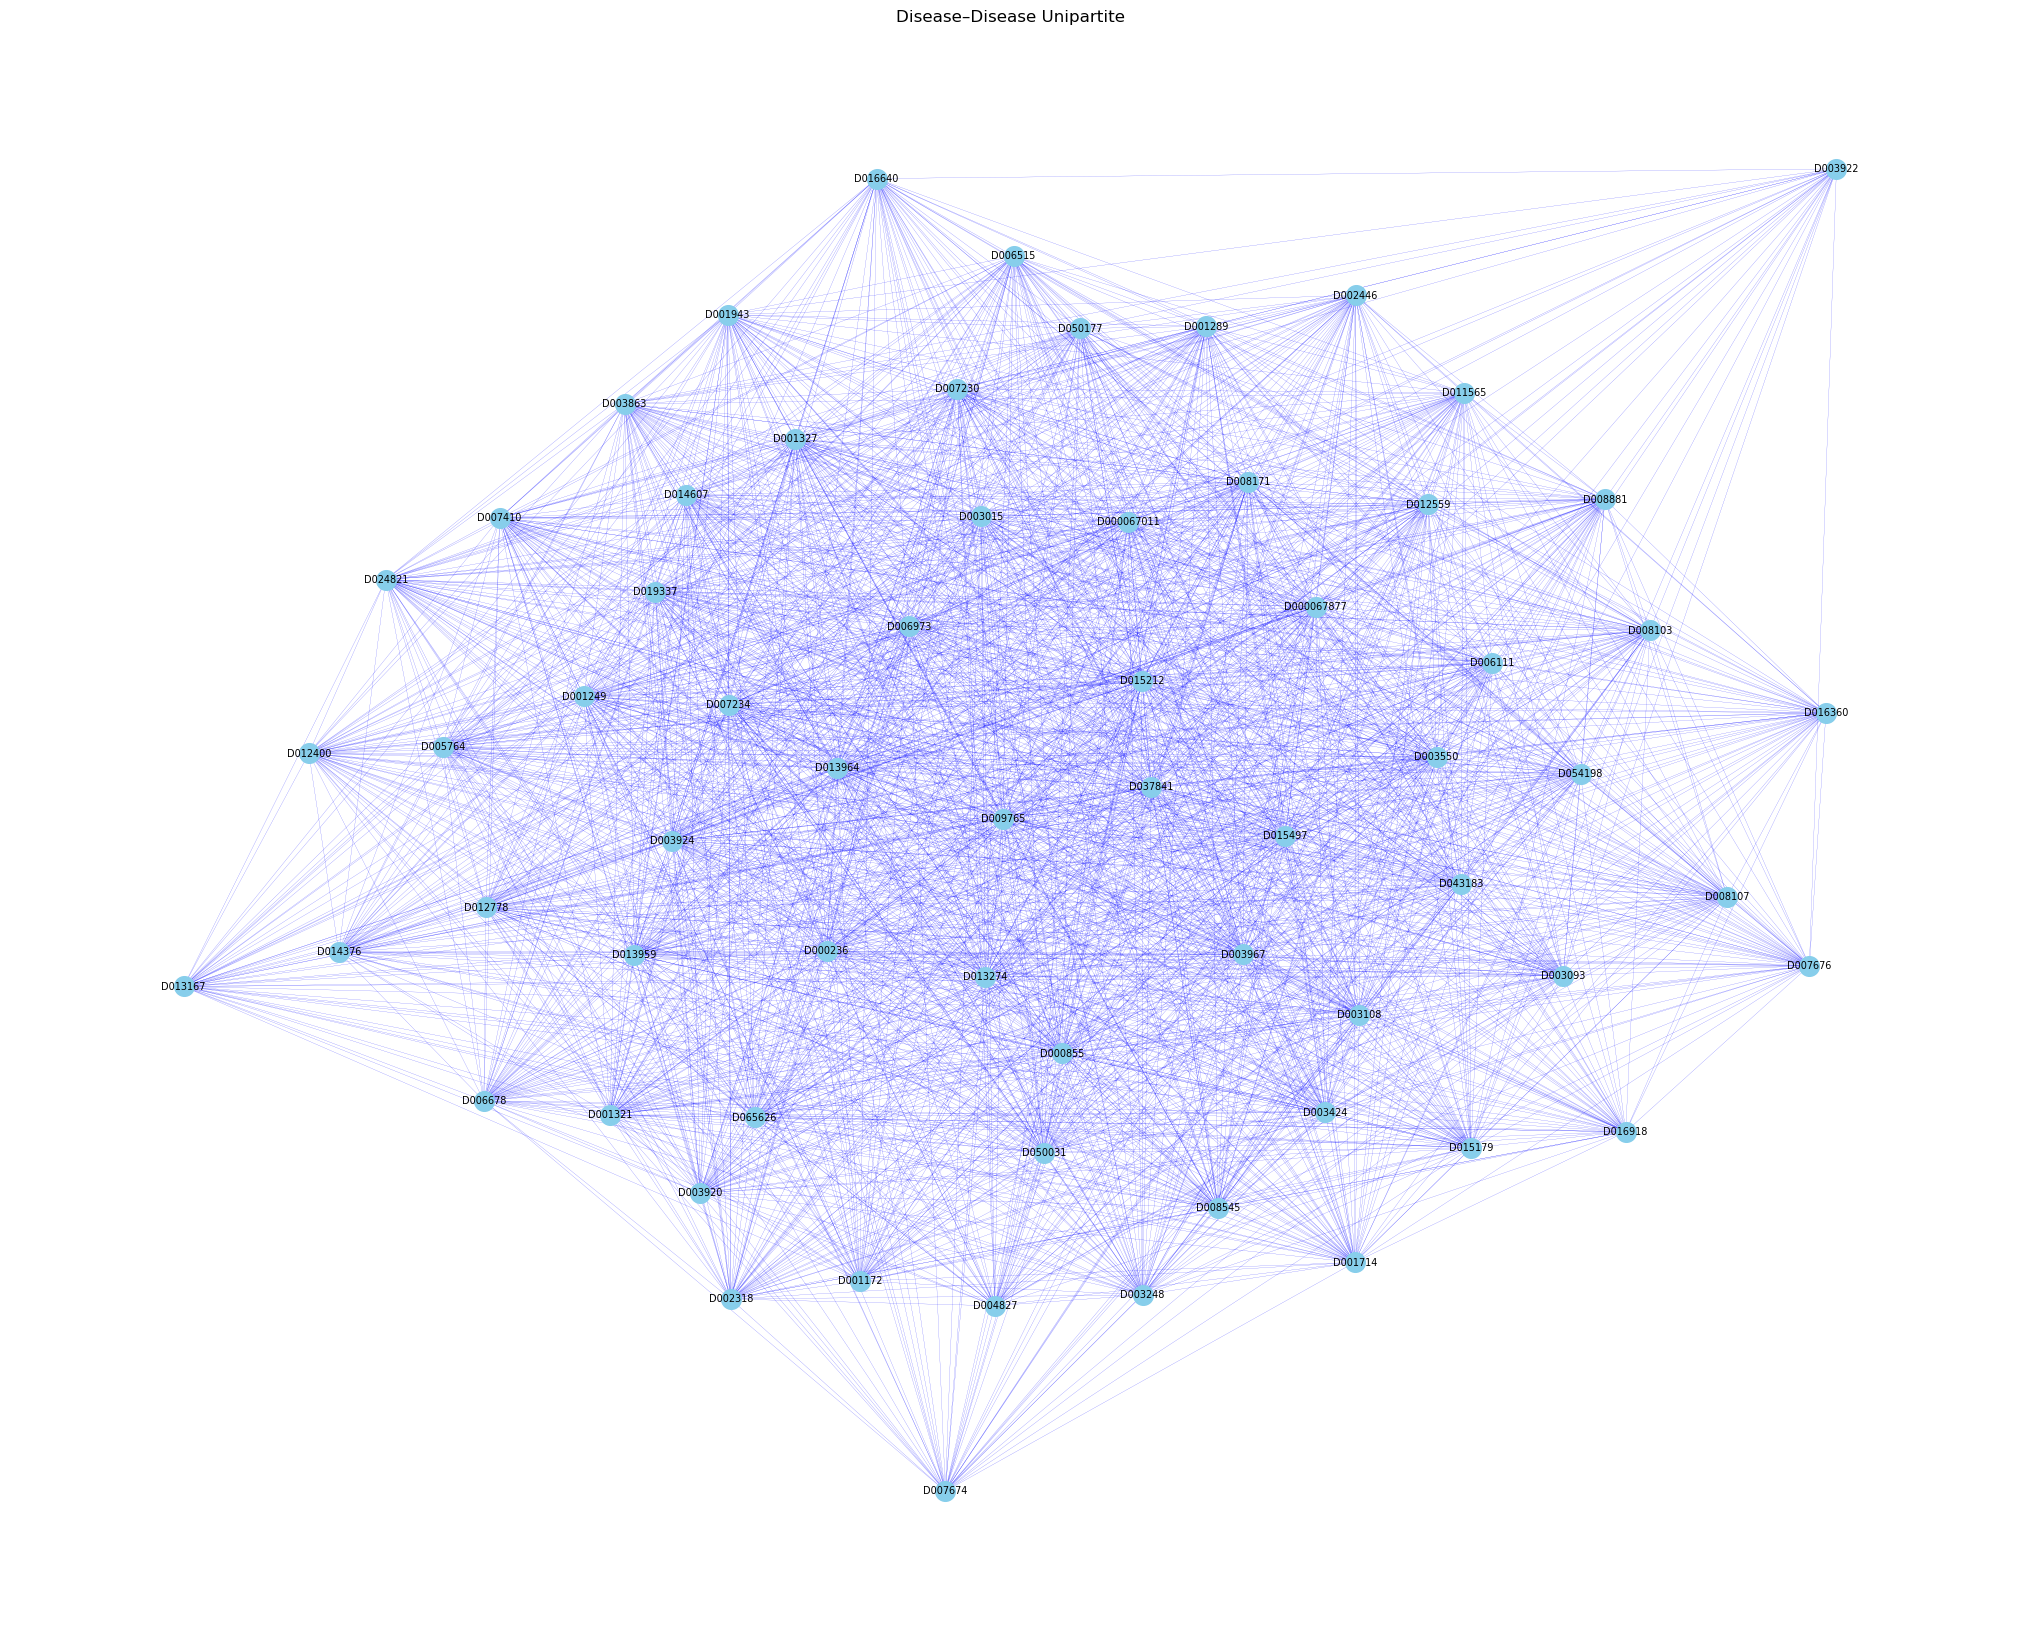

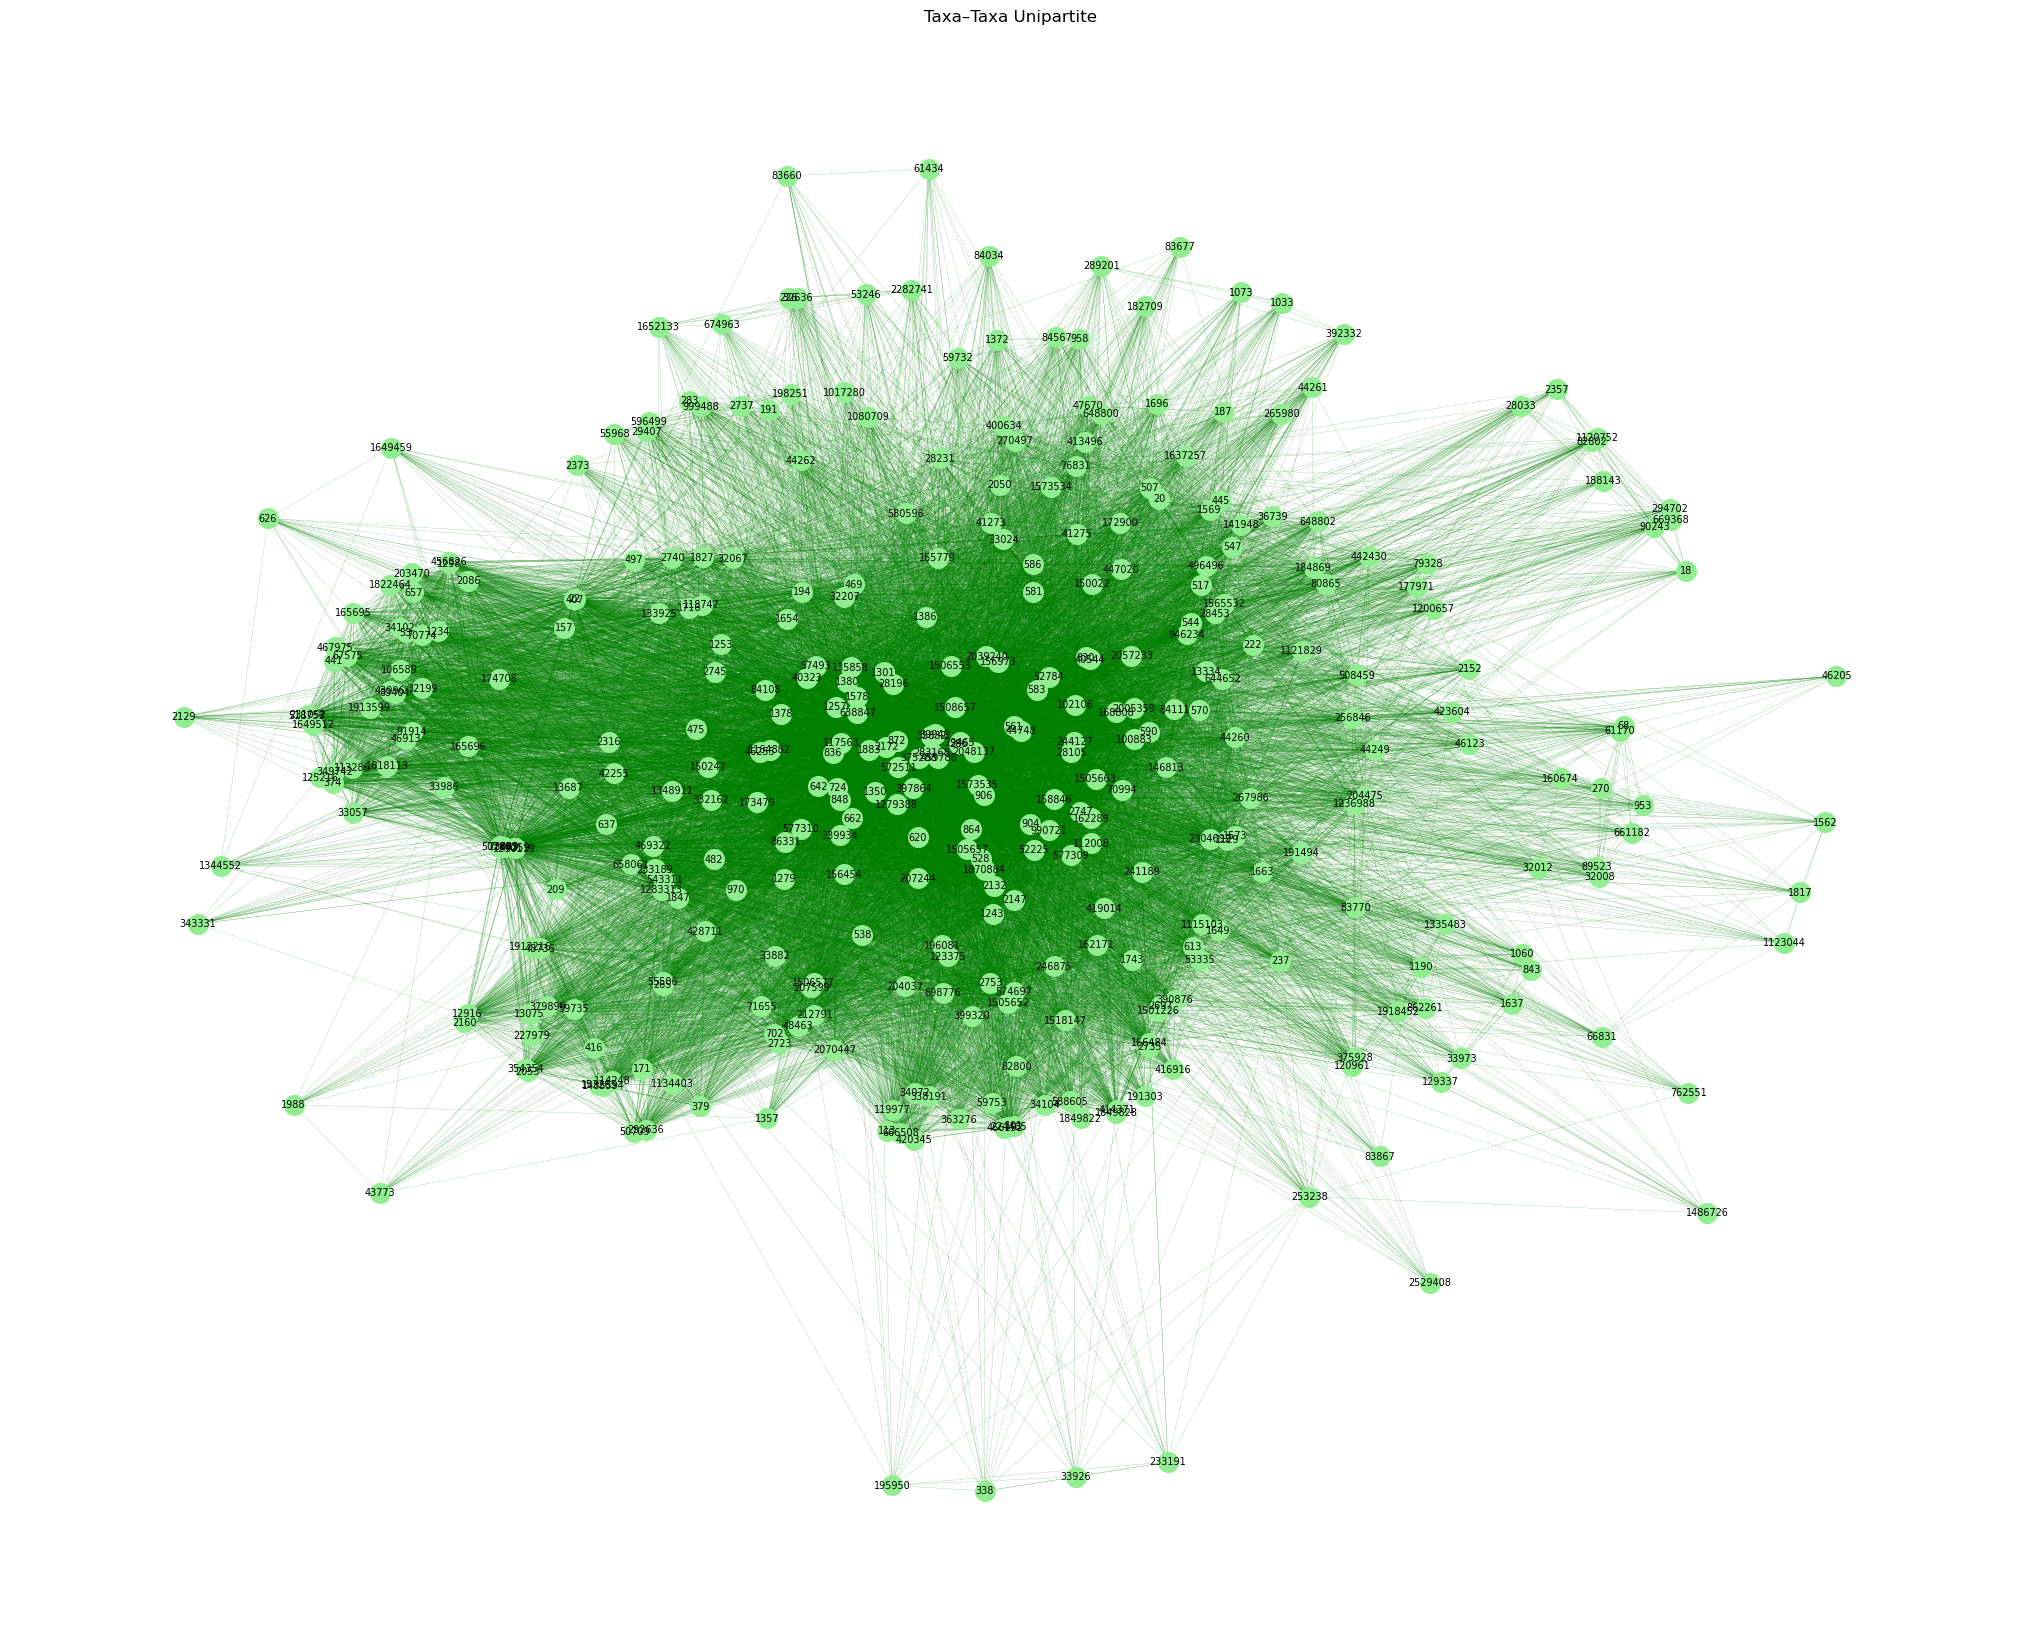

In [48]:
# Separate the two node sets from B
disease_nodes = [n for n, d in B.nodes(data=True) if d["bipartite"] == 0]
taxa_nodes    = [n for n, d in B.nodes(data=True) if d["bipartite"] == 1]

# Simple unipartite projections
G_disease = bipartite.projected_graph(B, disease_nodes)
G_taxa    = bipartite.projected_graph(B, taxa_nodes)

def describe_graph(G, name):
    n = G.number_of_nodes()
    e = G.number_of_edges()
    max_possible_edges = n * (n - 1) / 2
    density = e / max_possible_edges if max_possible_edges else 0
    deg = np.array([G.degree(n) for n in G.nodes()])
    print(f"""
{name} Summary:
- Nodes: {n}
- Edges: {e}
- Density: {density:.4f}
- Degree: mean {deg.mean():.2f}, median {np.median(deg):.2f}, min {deg.min()}, max {deg.max()}
""")

# Print summaries
describe_graph(G_disease, "Disease–Disease Unipartite")
describe_graph(G_taxa, "Taxa–Taxa Unipartite")

# Plot Disease–Disease
plt.figure(figsize=(20, 16))
nx.draw(G_disease, with_labels=True, node_color="skyblue",
        node_size=200, font_size=7, width=0.1, edge_color='blue')
plt.title("Disease–Disease Unipartite")
plt.axis("off")
plt.show()

# Plot Taxa–Taxa
plt.figure(figsize=(20, 16))
nx.draw(G_taxa, with_labels=True, node_color="lightgreen",
        node_size=200, font_size=7, width=0.1, edge_color='green')
plt.title("Taxa–Taxa Unipartite")
plt.axis("off")
plt.show()


In [49]:

# Save bipartite
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/network_analysis/bipartite_genus_network.gpickle", "wb") as f:
    pickle.dump(B, f)

# Save unipartite (disease)
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/network_analysis/unipartite_disease_genus.gpickle", "wb") as f:
    pickle.dump(G_disease, f)

# Save unipartite (taxa)
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/network_analysis/unipartite_taxa_genus.gpickle", "wb") as f:
    pickle.dump(G_taxa, f)


=== Ubiquity Threshold Selection ===
Threshold (count): 25 diseases
Fraction (tau)   : 0.38 of M=65
Taxa filtered    : 25 / 387 (6.5%)
Taxa retained    : 362 / 387 (93.5%)


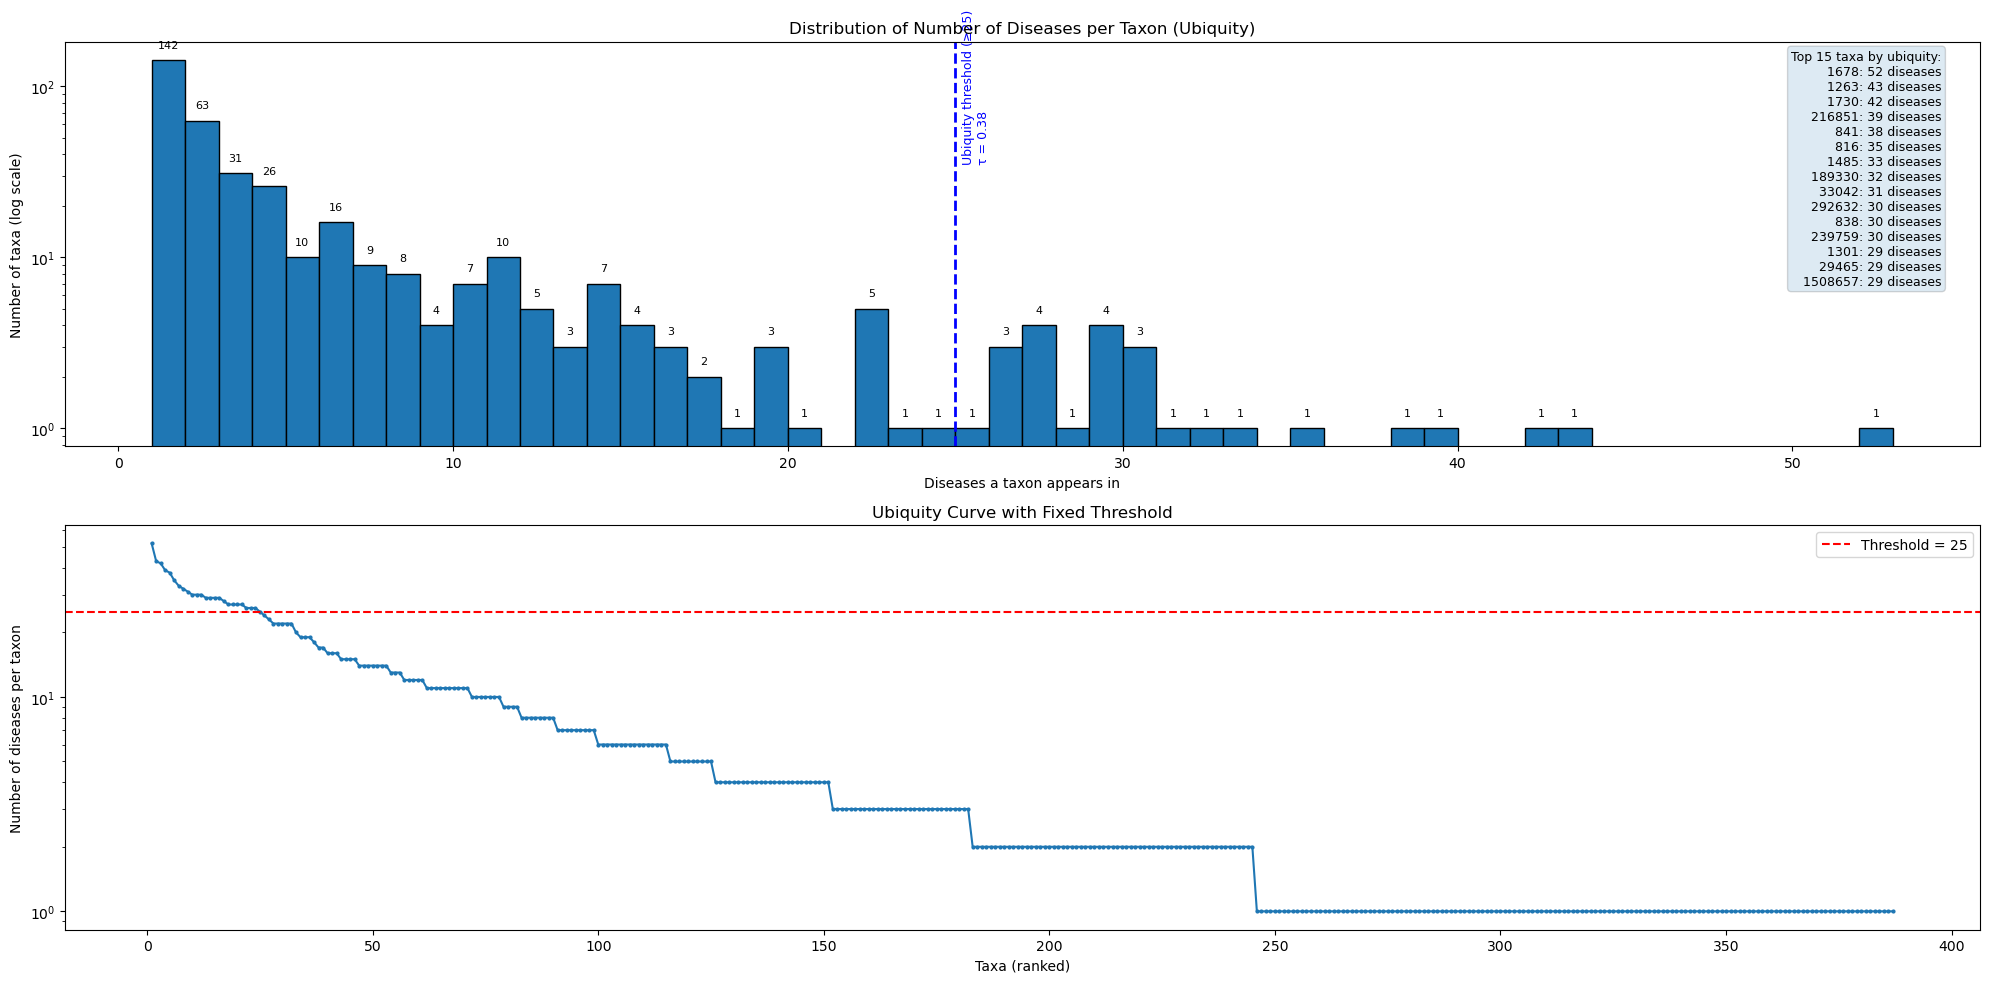


First 20 taxa to remove: [459786, 39948, 1678, 239759, 189330, 216851, 33042, 1301, 292632, 29465, 286, 283168, 397864, 816, 1508657, 1730, 838, 841, 44748, 1485]


In [51]:
# === UBIQUITY FILTER: FIXED THRESHOLD ONLY ===
# Requirements: numpy, pandas, matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
TOP_N = 15                 # how many top taxa to list
UBIQ_THRESHOLD = 25        # filter taxa in ≥ this many diseases
M = 65                     # total number of diseases
FIGSIZE = (20, 10)

# ---------- 1) Prepare unique (disease, taxon) pairs ----------
dfu = df_genus_network[["disease", "ncbi_taxon_id"]].drop_duplicates()

# ---------- 2) Ubiquity counts ----------
taxon_ubiq_counts = (
    dfu.groupby("ncbi_taxon_id")["disease"]
       .nunique()
       .sort_values(ascending=False)
       .rename("ubiquity")
)

# ---------- 3) Summary stats ----------
tau = UBIQ_THRESHOLD / float(M) if M else np.nan
n_taxa_total = len(taxon_ubiq_counts)
n_filtered = int((taxon_ubiq_counts >= UBIQ_THRESHOLD).sum())

print("=== Ubiquity Threshold Selection ===")
print(f"Threshold (count): {UBIQ_THRESHOLD} diseases")
print(f"Fraction (tau)   : {tau:.2f} of M={M}")
print(f"Taxa filtered    : {n_filtered} / {n_taxa_total} ({n_filtered/n_taxa_total:.1%})")
print(f"Taxa retained    : {n_taxa_total - n_filtered} / {n_taxa_total} ({(n_taxa_total - n_filtered)/n_taxa_total:.1%})")

# ---------- 4) Plot ----------
fig, axes = plt.subplots(2, 1, figsize=FIGSIZE)

# Subplot 1: Histogram
bins = np.arange(1, taxon_ubiq_counts.max() + 2)
counts, edges, patches = axes[0].hist(taxon_ubiq_counts, bins=bins, edgecolor="black")
axes[0].set_yscale("log")
axes[0].set_xlabel("Diseases a taxon appears in")
axes[0].set_ylabel("Number of taxa (log scale)")
axes[0].set_title("Distribution of Number of Diseases per Taxon (Ubiquity)")

# Label bars
for c, p in zip(counts, patches):
    if c > 0:
        cx = p.get_x() + p.get_width() / 2
        axes[0].text(cx, c * 1.15, f"{int(c)}", ha="center", va="bottom", fontsize=8)

# Threshold line + label
ylab = counts[counts > 0].max()
axes[0].axvline(UBIQ_THRESHOLD, linestyle="--", linewidth=2, color="blue")
axes[0].text(UBIQ_THRESHOLD + 0.2, ylab * 0.7,
             f"Ubiquity threshold (≥{UBIQ_THRESHOLD})\nτ = {tau:.2f}",
             rotation=90, va="center", color="blue", fontsize=9)

# Top taxa annotation
top_rows = taxon_ubiq_counts.head(TOP_N)
top_text = "\n".join([f"{int(tid)}: {ub} diseases" for tid, ub in top_rows.items()])
axes[0].text(0.98, 0.98, f"Top {TOP_N} taxa by ubiquity:\n{top_text}",
             transform=axes[0].transAxes, ha="right", va="top",
             bbox=dict(boxstyle="round", alpha=0.15), fontsize=9)

# Subplot 2: Ubiquity rank curve
x = np.arange(1, len(taxon_ubiq_counts) + 1)
y = taxon_ubiq_counts.values
axes[1].plot(x, y, marker="o", markersize=2)
axes[1].axhline(UBIQ_THRESHOLD, linestyle="--", color="red",
                label=f"Threshold = {UBIQ_THRESHOLD}")
axes[1].set_yscale("log")
axes[1].set_xlabel("Taxa (ranked)")
axes[1].set_ylabel("Number of diseases per taxon")
axes[1].set_title("Ubiquity Curve with Fixed Threshold")
axes[1].legend()

plt.tight_layout()
plt.show()

# ---------- 5) Taxa to remove ----------
taxa_to_remove = set(taxon_ubiq_counts.index[taxon_ubiq_counts >= UBIQ_THRESHOLD])
print(f"\nFirst 20 taxa to remove: {list(taxa_to_remove)[:20]}")


In [52]:
# --- Apply ubiquity filter ---
taxa_to_remove = set(taxon_ubiq_counts.index[taxon_ubiq_counts >= UBIQ_THRESHOLD])

# Filter df_genus_network to keep only taxa below the threshold
df_genus_network_filtered = df_genus_network[~df_genus_network["ncbi_taxon_id"].isin(taxa_to_remove)].copy()

print(f"Filtered dataset shape: {df_genus_network_filtered.shape}")
print(f"Removed {len(taxa_to_remove)} taxa, kept {df_genus_network_filtered['ncbi_taxon_id'].nunique()} unique taxa")

# OPTIONAL: inspect
df_genus_network_filtered.head()


Filtered dataset shape: (1545, 2)
Removed 25 taxa, kept 362 unique taxa


disease  ncbi_taxon_id
0  D003924            570
2  D003924            872
3  D003924            904
4  D003924            906
8  D003924           2753